# Biodiversity in National Parks

## Import modules

In [308]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
plt.style.use('ggplot')
colors = [c for c in mcolors.TABLEAU_COLORS]

## Import data into dataframes

There are two CSV files:

* species_info.csv - contains data about different species and their conservation status
* observations.csv - holds recorded sightings of different species at several national parks for the past 7 days.

In [309]:
species = pd.read_csv('species_info.csv')
species['common_name_1'] = species.common_names.apply(lambda s: s.split(sep=',')[0])
species.head()

,category,scientific_name,common_names,conservation_status,common_name_1
0,Mammal,Clethrionomys gapperi gapperi,Gapper's Red-Backed Vole,NaN,Gapper's Red-Backed Vole
1,Mammal,Bos bison,"American Bison, Bison",NaN,American Bison
2,Mammal,Bos taurus,"Aurochs, Aurochs, Domestic Cattle (Feral), Dom...",NaN,Aurochs
3,Mammal,Ovis aries,"Domestic Sheep, Mouflon, Red Sheep, Sheep (Feral)",NaN,Domestic Sheep
4,Mammal,Cervus elaphus,Wapiti Or Elk,NaN,Wapiti Or Elk


In [310]:
species.scientific_name.value_counts().sort_values(ascending=False)

Castor canadensis           3
Hypochaeris radicata        3
Columba livia               3
Puma concolor               3
Streptopelia decaocto       3
                           ..
Phoradendron juniperinum    1
Phoradendron libocedri      1
Phoradendron pauciflorum    1
Phoradendron villosum       1
Tribulus terrestris         1
Name: scientific_name, Length: 5541, dtype: int64

In [311]:
species.drop_duplicates(subset=['scientific_name'],inplace=True)

In [312]:
species.conservation_status.value_counts(dropna=False).sort_values(ascending=False)

NaN                   5363
Species of Concern     151
Endangered              15
Threatened               9
In Recovery              3
Name: conservation_status, dtype: int64

In [313]:
status_DD={'conservation_status':'Data deficient'}
species.fillna(value=status_DD,inplace=True)

In [314]:
observ = pd.read_csv('observations.csv')
observ.describe()

,observations
count,23296.000000
mean,142.287904
std,69.890532
min,9.000000
25%,86.000000
50%,124.000000
75%,195.000000
max,321.000000


## Explore and explain data

* How many species are we considering?
* What is the distribution of conservation_status for animals?
* Are certain types of species more likely to be endangered?
* Are the differences between species and their conservation status significant?
* Which species were spotted the most at each park?

## How many species are we considering?

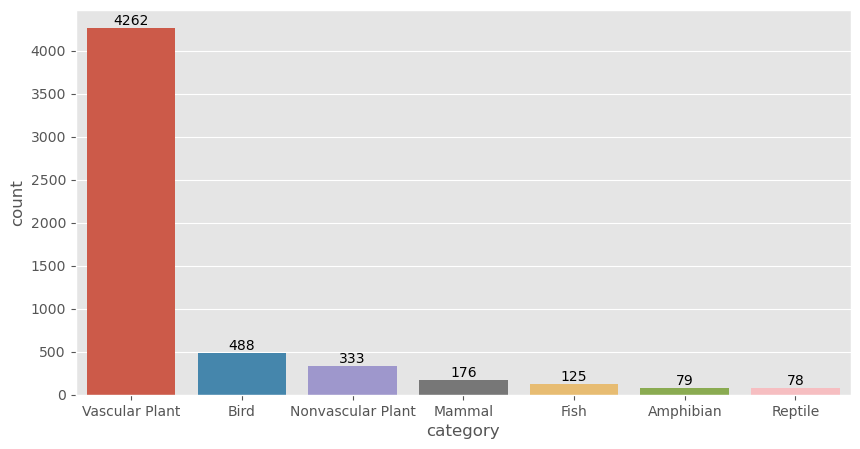

In [315]:
fig0, ax0 = plt.subplots(figsize=(10,5))
sns.countplot(data=species,x='category',order=species.category.value_counts().index)
_ = ax0.bar_label(ax0.containers[0])

## What is the distribution of conservation statuses for animals?

In [316]:
animal_categories = [cat for cat in species.category.unique() if 'Plant' not in cat]
animal_species = species.loc[species.category.isin(animal_categories)]
animal_species.category.value_counts()

Bird         488
Mammal       176
Fish         125
Amphibian     79
Reptile       78
Name: category, dtype: int64

In [317]:
animal_statuses=animal_species.groupby(by=['category','conservation_status'],as_index=False).scientific_name.count()

In [318]:
summary_status=animal_species.groupby(by=['conservation_status'],as_index=False).scientific_name.count()
summary_status['category']='Total'
animal_statuses=pd.concat(([animal_statuses,summary_status]))
animal_statuses.rename(columns={'scientific_name':'number'},inplace=True)
animal_statuses

,category,conservation_status,number
0,Amphibian,Data deficient,72
1,Amphibian,Endangered,1
2,Amphibian,Species of Concern,4
3,Amphibian,Threatened,2
4,Bird,Data deficient,413
5,Bird,Endangered,4
6,Bird,In Recovery,3
7,Bird,Species of Concern,68
8,Fish,Data deficient,115
9,Fish,Endangered,3


In [319]:
animal_categories.append('Total')
sts=animal_statuses.conservation_status.unique()
categories=animal_statuses.category.unique()
for cat in categories:
    for st in sts:
        if len(animal_statuses.loc[(animal_statuses.category==cat)
                                   &(animal_statuses.conservation_status==st)]) == 0:
            new_row_dic = {'category':[cat],'conservation_status':[st],'number':[0]}
            new_row = pd.DataFrame(new_row_dic)
            animal_statuses=pd.concat([animal_statuses,new_row]).reset_index(drop=True)
animal_statuses.sort_values(by=['category','conservation_status'],inplace=True)
animal_statuses.head()

,category,conservation_status,number
0,Amphibian,Data deficient,72
1,Amphibian,Endangered,1
23,Amphibian,In Recovery,0
2,Amphibian,Species of Concern,4
3,Amphibian,Threatened,2


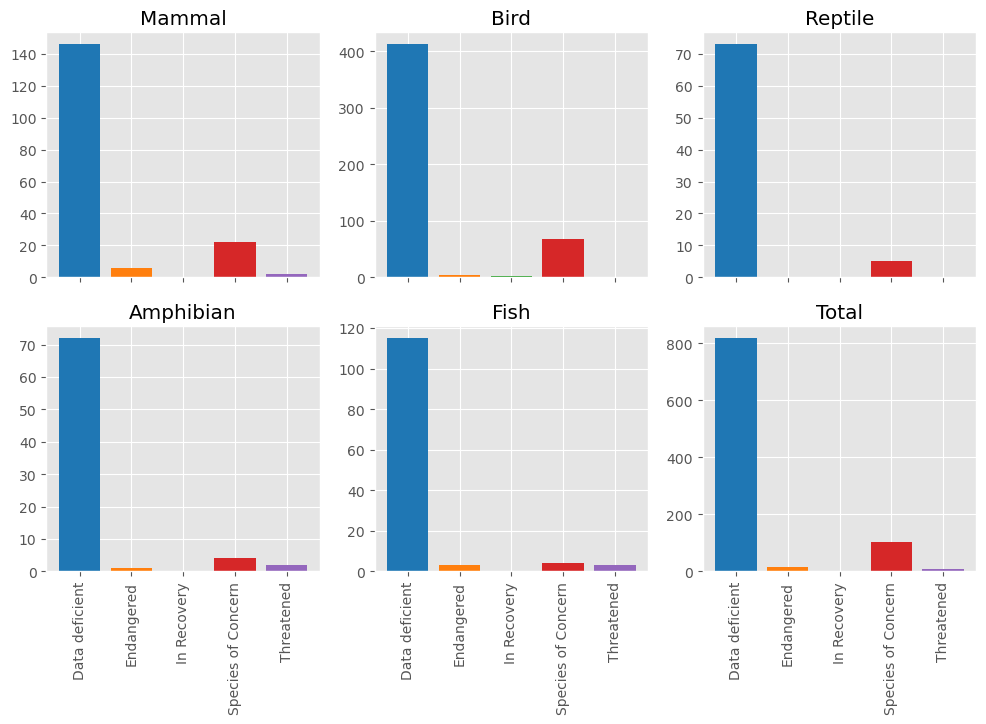

In [320]:
fig1, axs1 = plt.subplots(2,3,figsize=(12,7),sharex=True)
for i, cat in enumerate(animal_categories):
    row, col = i // 3, i % 3
    df = animal_statuses.loc[(animal_statuses.category == cat)]
    axs1[row,col].bar(x=df.conservation_status,height=df.number,color=colors)
    axs1[row,col].set(title=cat)
    axs1[row,col].set_xticks(range(len(df.conservation_status)))
    axs1[row,col].set_xticklabels(labels=df.conservation_status,rotation=90)    

## Are certain types of species more likely to be endangered?

In [321]:
animal_statuses['is_endangered'] = animal_statuses.conservation_status != 'Data deficient'

In [322]:
animal_endangered = animal_statuses.groupby(['category','is_endangered'],as_index=False).number.sum()
animal_endangered

,category,is_endangered,number
0,Amphibian,False,72
1,Amphibian,True,7
2,Bird,False,413
3,Bird,True,75
4,Fish,False,115
5,Fish,True,10
6,Mammal,False,146
7,Mammal,True,30
8,Reptile,False,73
9,Reptile,True,5


In [323]:
animal_endangered= animal_endangered.pivot(index='category',columns=['is_endangered'],values='number')
animal_endangered

is_endangered,False,True
category,,
Amphibian,72,7
Bird,413,75
Fish,115,10
Mammal,146,30
Reptile,73,5
Total,819,127


In [324]:
animal_endangered.reset_index(inplace=True)
animal_endangered.rename(columns={False:'not_endangered',True:'endangered'},inplace=True)
animal_endangered

is_endangered,category,not_endangered,endangered
0,Amphibian,72,7
1,Bird,413,75
2,Fish,115,10
3,Mammal,146,30
4,Reptile,73,5
5,Total,819,127


In [325]:
animal_endangered['perc'] = round(animal_endangered.endangered / (animal_endangered.endangered+animal_endangered.not_endangered),3)*100

In [326]:
animal_endangered

is_endangered,category,not_endangered,endangered,perc
0,Amphibian,72,7,8.9
1,Bird,413,75,15.4
2,Fish,115,10,8.0
3,Mammal,146,30,17.0
4,Reptile,73,5,6.4
5,Total,819,127,13.4


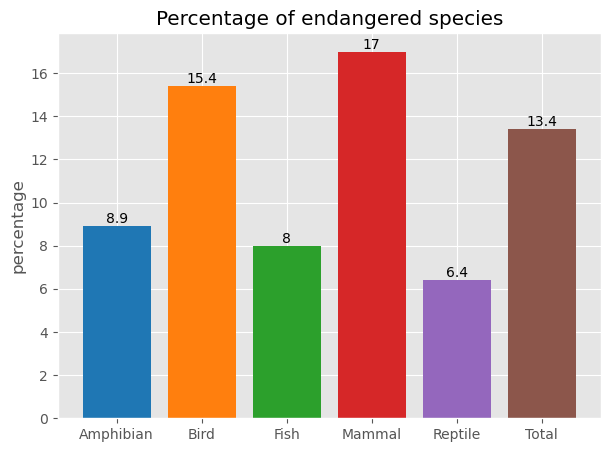

In [327]:
fig2, ax2 = plt.subplots(figsize=(7,5))
_ = ax2.bar(x=animal_endangered.category,height=animal_endangered.perc,color=colors)
_ = ax2.bar_label(ax2.containers[0])
_ = ax2.set(title='Percentage of endangered species',ylabel='percentage')

It is easy to see that the categories with the most endangered species are **_birds_** and **_mammals_**

## Which species were spotted the most at each park?

In [328]:
species_observ = pd.merge(left=observ,right=species,on='scientific_name')
species_observ.head()

,scientific_name,park_name,observations,category,common_names,conservation_status,common_name_1
0,Vicia benghalensis,Great Smoky Mountains National Park,68,Vascular Plant,"Purple Vetch, Reddish Tufted Vetch",Data deficient,Purple Vetch
1,Vicia benghalensis,Yosemite National Park,148,Vascular Plant,"Purple Vetch, Reddish Tufted Vetch",Data deficient,Purple Vetch
2,Vicia benghalensis,Yellowstone National Park,247,Vascular Plant,"Purple Vetch, Reddish Tufted Vetch",Data deficient,Purple Vetch
3,Vicia benghalensis,Bryce National Park,104,Vascular Plant,"Purple Vetch, Reddish Tufted Vetch",Data deficient,Purple Vetch
4,Neovison vison,Great Smoky Mountains National Park,77,Mammal,American Mink,Data deficient,American Mink


In [331]:
spotted=species_observ.loc[df1.category.isin(animal_categories)].\
    groupby(by=['park_name','common_name_1'],as_index=False).observations.sum()
parks = spotted.park_name.unique()

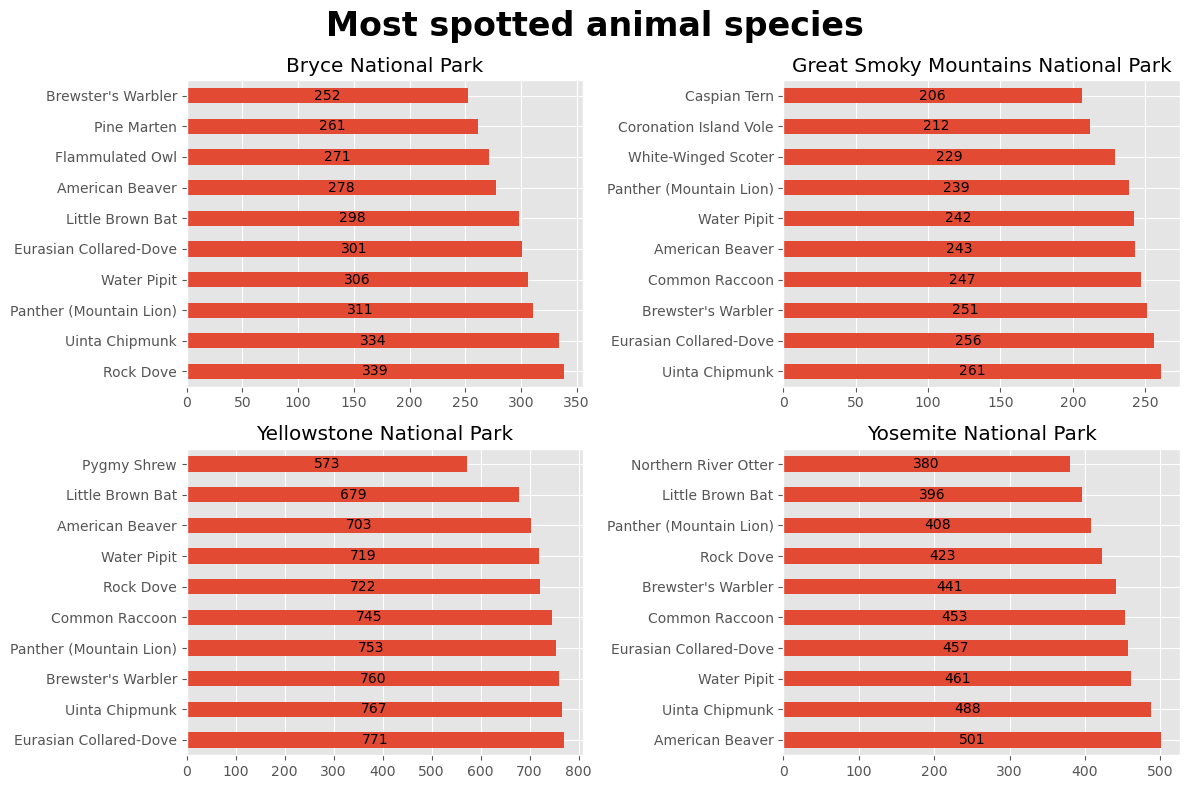

In [343]:
fig3, axs3 = plt.subplots(2,2,figsize=(12,8))
fig3.suptitle('Most spotted animal species',fontsize=24,fontweight='bold')
for i, park in enumerate(parks):
    row, col = i // 2, i % 2
    top_10=spotted.loc[spotted.park_name==park].sort_values(by=['observations'],ascending=False)[:10]
    top_10.plot(kind='barh', y='observations', x="common_name_1", ax=axs3[row,col],legend=False)
    axs3[row,col].set(title=park,ylabel='')
    _ = axs3[row,col].bar_label(axs3[row,col].containers[0],label_type='center')
fig3.tight_layout()   